DMML Assignment 1

Om Ambaye BMC202006 

Alok Dhar Dubey BMP202002

In [131]:
#importing various packages
import time
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import tracemalloc
tracemalloc.start()
start = time.time()


Reading Data

In [132]:
path_to_file="C:/CMI/SEM 6/DMML/Assignment1/movie-data/Data for repository.csv"
film_data=pd.read_csv(path_to_file, sep=",")
film_data.head()

,Movie Name,Release Period,Whether Remake,Whether Franchise,Genre,New Actor,New Director,New Music Director,Lead Star,Director,Music Director,Number of Screens,Revenue(INR),Budget(INR)
0,Golden Boys,Normal,No,No,suspense,Yes,No,No,Jeet Goswami,Ravi Varma,Baba Jagirdar,5,5000000,85000
1,Kaccha Limboo,Holiday,No,No,drama,Yes,No,Yes,Karan Bhanushali,Sagar Ballary,Amardeep Nijjer,75,15000000,825000
2,Not A Love Story,Holiday,No,No,thriller,No,No,No,Mahie Gill,Ram Gopal Verma,Sandeep Chowta,525,75000000,56700000
3,Qaidi Band,Holiday,No,No,drama,Yes,No,No,Aadar Jain,Habib Faisal,Amit Trivedi,800,210000000,4500000
4,Chaatwali,Holiday,No,No,adult,Yes,Yes,Yes,Aadil Khan,Aadil Khan,Babloo Ustad,1,1000000,1075000


Modifying the Dataset

We drop the column 'Movie Name' because that is different for each and provides no insight. Although the values are very different for "Director', 'Lead Star', 'Music Director', we still include them because their popularity and fan following plays a huge role. We make a new column 'hit_or_flop' which tells if the movie is a hit or a flop. This is our target variable. Note that in the original dataset, revenue and budget columns are interchanged(which is also mentioned on Kaggle) and hence we intercahnge the column headings first. Then we drop the column revenue but not the budget because budget of a movie is decided at the time when movie is made. So this is known beforehand.

In [133]:
film_data['Revenue(INR)'], film_data['Budget(INR)'] = film_data['Budget(INR)'] , film_data['Revenue(INR)']
film_data=film_data.drop(columns=['Movie Name'])

#Changing the ordinal variables manually preserving the order
film_data['Whether Remake'] = film_data['Whether Remake'].map({'Yes':1, 'No':0})
film_data['Whether Franchise'] = film_data['Whether Franchise'].map({'Yes':1, 'No':0})
film_data['New Actor'] = film_data['New Actor'].map({'Yes':1, 'No':0})
film_data['New Director'] = film_data['New Director'].map({'Yes':1, 'No':0})
film_data['New Music Director'] = film_data['New Music Director'].map({'Yes':1, 'No':0})
film_data['Release Period'] = film_data['Release Period'].map({'Normal':0, 'Holiday':1})

#Changing some of the categorical attributes to numerical attributes using Label Encoding.
film_data=pd.get_dummies(film_data,columns=['Genre', 'Director', 'Lead Star', 'Music Director'])

#creating a hit_or_flop column
hit_or_flop=[' ']*1698
for i in range(1698):
    if film_data.at[i,'Budget(INR)']<film_data.at[i,'Revenue(INR)']:
        hit_or_flop[i]='hit'
    else:
        hit_or_flop[i]='flop'   

film_data=film_data.assign(Hit_or_Flop=hit_or_flop)

film_data=film_data.drop(columns=['Revenue(INR)'])

film_data.head()



,Release Period,Whether Remake,Whether Franchise,New Actor,New Director,New Music Director,Number of Screens,Budget(INR),Genre_action,Genre_adult,...,Music Director_Vivek Prakash,Music Director_Vivek Priyadarshan,Music Director_Wayne Sharpe,Music Director_Yasin Darbar,Music Director_Yuvan Shankar Raja,Music Director_Zakir Hussain,Music Director_Zubeen Garg,Music Director_Zubin Balaporia,Music Director_Zubunnisa Bangash,Hit_or_Flop
0,0,0,0,1,0,0,5,5000000,0,0,...,0,0,0,0,0,0,0,0,0,flop
1,1,0,0,1,0,1,75,15000000,0,0,...,0,0,0,0,0,0,0,0,0,flop
2,1,0,0,0,0,0,525,75000000,0,0,...,0,0,0,0,0,0,0,0,0,flop
3,1,0,0,1,0,0,800,210000000,0,0,...,0,0,0,0,0,0,0,0,0,flop
4,1,0,0,1,1,1,1,1000000,0,1,...,0,0,0,0,0,0,0,0,0,hit


Training the Data

In [134]:
X = film_data.drop(['Hit_or_Flop'], axis = 1)
y = film_data['Hit_or_Flop']
#Splitting the data into training and test samples (75-25 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


Fitting the Decision Tree Classifier

In [135]:
DT = DecisionTreeClassifier(max_depth = 5, random_state=42)
DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Visualising the Tree

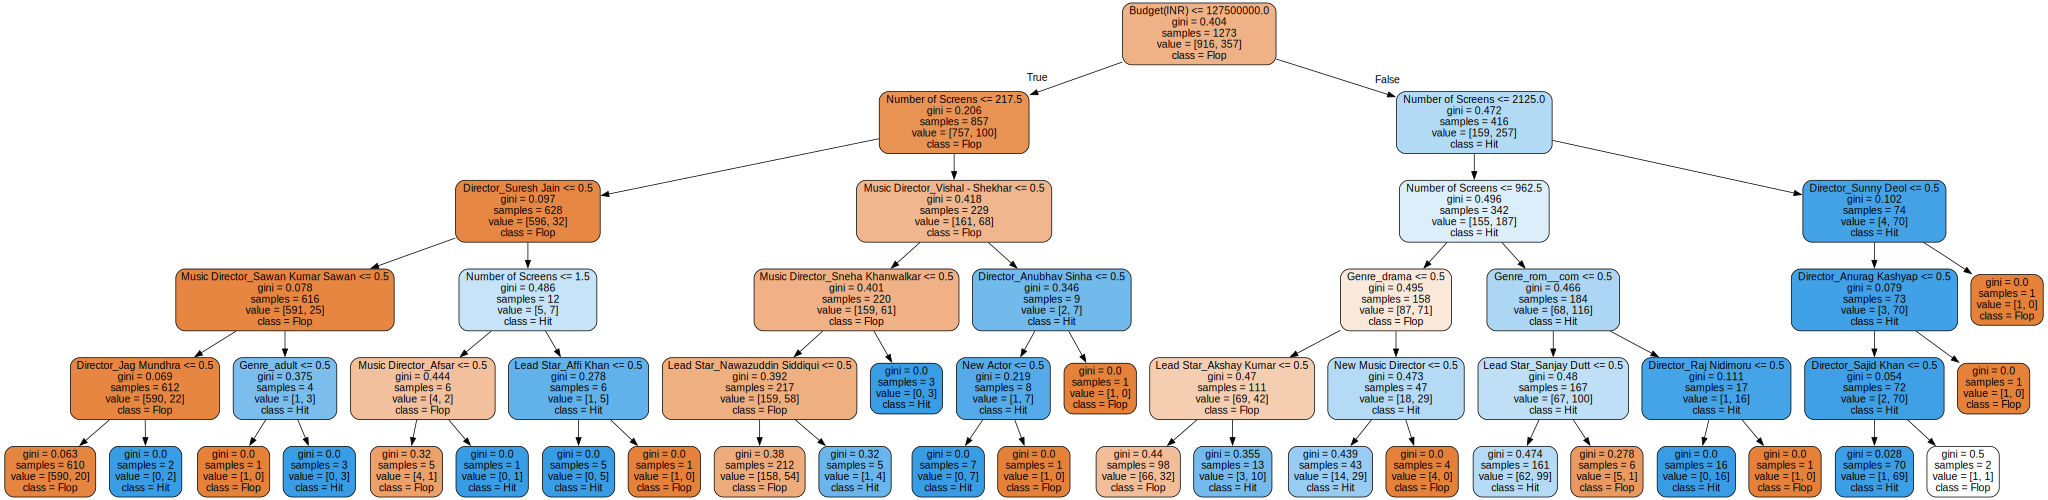

In [136]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from sklearn.tree import export_graphviz

export_graphviz(
        DT,
        out_file=str(IMAGES_PATH / "movie_tree.dot"),
        feature_names=X.columns,
        class_names=['Flop','Hit'],
        rounded=True,
        filled=True
    )
from graphviz import Source

Source.from_file(IMAGES_PATH / "movie_tree.dot")    

Testing the Tree 

In [137]:
y_pred = DT.predict(X_test)
y_test = np.array(y_test).flatten()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        flop       0.87      0.90      0.88       313
         hit       0.69      0.61      0.64       112

    accuracy                           0.82       425
   macro avg       0.78      0.75      0.76       425
weighted avg       0.82      0.82      0.82       425



In [138]:
print("Accuracy for Decision Tree: ", np.round(sklearn.metrics.accuracy_score(y_test, y_pred)*100,2), '%')
print("Precision for Decision Tree: ", np.round(sklearn.metrics.precision_score(y_test, y_pred,pos_label='hit')*100,2), '%')
print("Recall for Decision Tree: ", np.round(sklearn.metrics.recall_score(y_test, y_pred,pos_label='hit')*100,2), '%')
print("F1 score for Decision Tree:", np.round(sklearn.metrics.f1_score(y_test, y_pred,pos_label='hit')*100,2), "\n")

Accuracy for Decision Tree:  82.35 %
Precision for Decision Tree:  68.69 %
Recall for Decision Tree:  60.71 %
F1 score for Decision Tree: 64.45 



Confusion Matrix

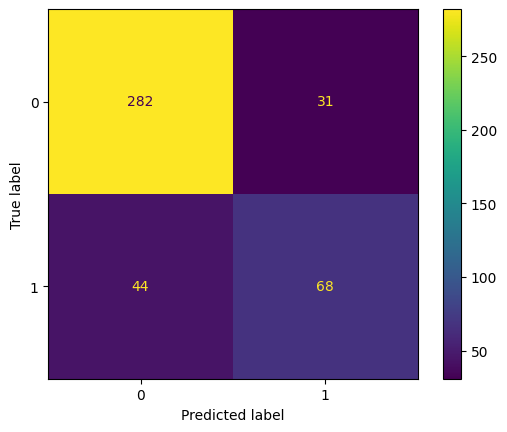

In [139]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Time and Memory consumed

In [140]:
current, peak = tracemalloc.get_traced_memory()  # take a snapshot of current memory usage
print(f"Current memory usage is {current / 10**6}MB\nPeak memory usage was {peak / 10**6}MB")

tracemalloc.stop()  # stop tracking memory usage

time.time()-start

Current memory usage is 15.015833MB
Peak memory usage was 51.719428MB


1.3056421279907227

Naive Bayes Classifier

In [141]:
tracemalloc.start()
start = time.time()
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(X_train, y_train)
MultinomialNB()

MultinomialNB()

Testing the Bayes classifier

In [142]:
y_pred = NB.predict(X_test)
y_test = np.array(y_test).flatten()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        flop       0.93      0.81      0.86       313
         hit       0.61      0.82      0.70       112

    accuracy                           0.81       425
   macro avg       0.77      0.81      0.78       425
weighted avg       0.84      0.81      0.82       425



In [143]:
print("Accuracy for Naive Bayes: ", np.round(sklearn.metrics.accuracy_score(y_test, y_pred)*100,2), '%')
print("Precision for Naive Bayes: ", np.round(sklearn.metrics.precision_score(y_test, y_pred,pos_label='hit')*100,2), '%')
print("Recall for Naive Bayes: ", np.round(sklearn.metrics.recall_score(y_test, y_pred,pos_label='hit')*100,2), '%')
print("F1 score for Naive Bayes:", np.round(sklearn.metrics.f1_score(y_test, y_pred,pos_label='hit')*100,2), "\n")

Accuracy for Naive Bayes:  81.18 %
Precision for Naive Bayes:  60.53 %
Recall for Naive Bayes:  82.14 %
F1 score for Naive Bayes: 69.7 



Confusion Matrix

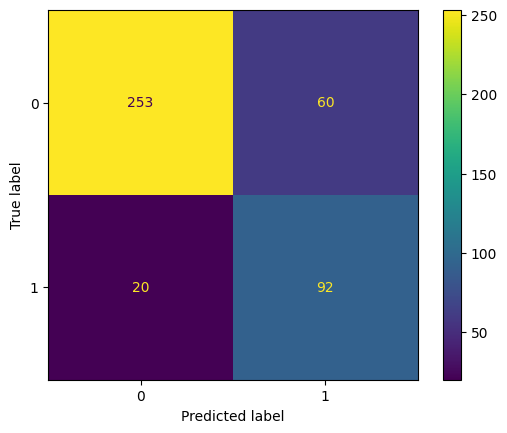

In [144]:
cm2 = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.show()

Time and Memory consumed

In [145]:
current, peak = tracemalloc.get_traced_memory()  # take a snapshot of current memory usage
print(f"Current memory usage is {current / 10**6}MB\nPeak memory usage was {peak / 10**6}MB")

tracemalloc.stop()  # stop tracking memory usage

time.time()-start

Current memory usage is 1.07939MB
Peak memory usage was 25.306447MB


0.6919779777526855